# **Immune Activation Patterns in Triple-Negative Breast Cancer**

### A gene-expression based analysis of tumor immune activity, subtype heterogeneity, and predictive modeling

This notebook analyzes breast cancer gene expression data to quantify immune activation, compare immune activity across tumor subtypes, discover intrinsic immune subgroups, and evaluate predictive models for TNBC classification.


## Background

Triple-negative breast cancer (TNBC) is an aggressive breast cancer subtype lacking estrogen receptor, progesterone receptor, and HER2 amplification. TNBC tumors are known to exhibit variable immune infiltration, which has important implications for prognosis and response to immunotherapy.

This study investigates whether immune activation signatures derived from gene expression data can:

1. Quantify tumor immune activity
2. Distinguish TNBC from other breast cancers
3. Reveal intrinsic immune subtypes
4. Predict TNBC status using machine learning


## Dataset and Preprocessing
Gene expression data were obtained from the GEO dataset GSE45827.
Microarray probe IDs were mapped to gene symbols using the GPL570 annotation.


In [2]:
import pandas as pd
import gzip
from io import StringIO

In [3]:
import gzip

file_path = "../data/GSE45827_series_matrix.txt.gz"

with gzip.open(file_path, 'rt') as f:
    lines = f.readlines()


In [4]:
data_lines = [line for line in lines if not line.startswith("!")]


In [5]:
data_str = "".join(data_lines)
expression = pd.read_csv(StringIO(data_str), sep="\t")


In [6]:
expression.shape   #(genes, samples)


(29873, 156)

In [7]:
expression.columns[:10]


Index(['ID_REF', 'GSM1116084', 'GSM1116085', 'GSM1116086', 'GSM1116087',
       'GSM1116088', 'GSM1116089', 'GSM1116090', 'GSM1116091', 'GSM1116092'],
      dtype='object')

In [8]:
expression = expression.set_index("ID_REF")

In [9]:
expression = expression.apply(pd.to_numeric, errors="coerce")


In [10]:
expression = expression.dropna(how="all")


In [11]:
expression.shape
expression.head()


,GSM1116084,GSM1116085,GSM1116086,GSM1116087,GSM1116088,GSM1116089,GSM1116090,GSM1116091,GSM1116092,GSM1116093,...,GSM1116229,GSM1116230,GSM1116231,GSM1116232,GSM1116233,GSM1116234,GSM1116235,GSM1116236,GSM1116237,GSM1116238
ID_REF,,,,,,,,,,,,,,,,,,,,,
1007_s_at,9.47065,9.67440,10.20800,10.11420,11.16360,10.00690,9.53932,9.00187,6.54074,10.35510,...,9.96811,10.10680,10.03290,9.84599,10.75850,10.55470,9.45290,10.80010,10.04640,11.42010
1053_at,8.36311,8.72194,7.78601,9.44537,7.71242,7.84274,7.56238,8.01540,9.37874,9.45426,...,7.25745,7.54377,7.41607,5.83454,8.83376,6.88277,6.83700,7.29371,7.71122,7.63877
117_at,5.95426,7.02523,6.39671,4.56023,5.29008,6.21590,6.42180,6.23554,5.43541,3.85652,...,8.35832,6.98743,4.50611,4.78051,4.55847,4.14597,6.10766,5.41169,4.57742,4.67159
1294_at,6.02119,7.24581,6.85310,5.42786,7.51120,5.79719,7.36700,7.17268,7.72472,4.79560,...,7.18591,7.74070,7.44448,7.03001,6.87039,6.37882,6.99674,8.37598,6.56774,7.40374
1316_at,3.22997,3.29352,3.26204,3.34766,3.59086,3.40108,3.27663,3.14212,3.28420,3.27900,...,3.50312,3.57309,3.31572,3.70289,4.82208,3.55309,3.23899,3.84879,3.28091,3.24882


In [12]:
file_path = "../data/GSE45827_series_matrix.txt.gz"

import gzip
with gzip.open(file_path, 'rt') as f:
    raw_lines = f.readlines()


In [13]:
meta_lines = [l for l in raw_lines if l.startswith("!Sample")]


In [14]:
for line in meta_lines:
    if "characteristics" in line.lower():
        print(line[:300])


!Sample_characteristics_ch1	"diagnosis: Breast cancer"	"diagnosis: Breast cancer"	"diagnosis: Breast cancer"	"diagnosis: Breast cancer"	"diagnosis: Breast cancer"	"diagnosis: Breast cancer"	"diagnosis: Breast cancer"	"diagnosis: Breast cancer"	"diagnosis: Breast cancer"	"diagnosis: Breast cancer"	"d
!Sample_characteristics_ch1	"tumor subtype: Basal"	"tumor subtype: Basal"	"tumor subtype: Her2"	"tumor subtype: Basal"	"tumor subtype: Her2"	"tumor subtype: Her2"	"tumor subtype: Basal"	"tumor subtype: Basal"	"tumor subtype: Basal"	"tumor subtype: Basal"	"tumor subtype: Basal"	"tumor subtype: Her2"	
!Sample_characteristics_ch1	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 8"	"batch: 9"	"batch: 9"	"batch: 
!Sample_characteristics_ch1	"hybridation: -1"	"hybridation: -1"	"hybridation: -1"	"hybridation: -

In [15]:
subtype_line = [l for l in raw_lines if "tumor subtype" in l][0]


In [16]:
parts = subtype_line.strip().split("\t")


In [17]:
subtypes = parts[1:]


In [18]:
subtypes = [s.replace('"','').replace("tumor subtype: ","") for s in subtypes]


In [19]:
subtypes[:20]


['Basal',
 'Basal',
 'Her2',
 'Basal',
 'Her2',
 'Her2',
 'Basal',
 'Basal',
 'Basal',
 'Basal',
 'Basal',
 'Her2',
 'Her2',
 'Her2',
 'Her2',
 'Basal',
 'Her2',
 'Basal',
 'Basal',
 'Her2']

In [20]:
len(subtypes)


155

In [21]:
expression.shape


(29873, 155)

In [22]:
metadata = pd.DataFrame({
    "Sample": expression.columns,
    "Subtype": subtypes
})


In [23]:
metadata.head()
metadata["Subtype"].value_counts()


Subtype
Basal                                41
Her2                                 30
Luminal B                            30
Luminal A                            29
cell origin: Breast carcinoma        12
N/A                                  11
cell origin: Breast mammary gland     2
Name: count, dtype: int64

In [24]:
metadata["TNBC"] = metadata["Subtype"] == "Basal"
metadata


,Sample,Subtype,TNBC
0,GSM1116084,Basal,True
1,GSM1116085,Basal,True
2,GSM1116086,Her2,False
3,GSM1116087,Basal,True
4,GSM1116088,Her2,False
...,...,...,...
150,GSM1116234,Luminal A,False
151,GSM1116235,Luminal A,False
152,GSM1116236,Luminal B,False
153,GSM1116237,Luminal B,False


In [25]:
expression.index[:10]


Index(['1007_s_at', '1053_at', '117_at', '1294_at', '1316_at', '1405_i_at',
       '1438_at', '1487_at', '1552256_a_at', '1552257_a_at'],
      dtype='object', name='ID_REF')

In [26]:
annot = pd.read_csv("../data/GPL570-55999.txt", sep="\t", comment="#", low_memory=False)


In [27]:
annot.columns[:20]


Index(['ID', 'GB_ACC', 'SPOT_ID', 'Species Scientific Name', 'Annotation Date',
       'Sequence Type', 'Sequence Source', 'Target Description',
       'Representative Public ID', 'Gene Title', 'Gene Symbol',
       'ENTREZ_GENE_ID', 'RefSeq Transcript ID',
       'Gene Ontology Biological Process', 'Gene Ontology Cellular Component',
       'Gene Ontology Molecular Function'],
      dtype='object')

In [28]:
annot_small = annot[["ID", "Gene Symbol"]]


In [29]:
annot_small = annot_small.dropna()


In [30]:
expression_with_gene = expression.merge(
    annot_small,
    left_index=True,
    right_on="ID"
)


In [31]:
expression_with_gene = expression_with_gene.set_index("Gene Symbol")


In [32]:
expression_with_gene = expression_with_gene.drop(columns=["ID"])


In [33]:
expression_with_gene.index[:20]


Index(['DDR1 /// MIR4640', 'RFC2', 'HSPA6', 'MIR5193 /// UBA7', 'THRA', 'CCL5',
       'EPHB3', 'ESRRA', 'SCARB1', 'TTLL12', 'LINC00152 /// LOC101930489',
       'MAPK1', 'MAPK1', 'ADAM32', 'PXK', 'PXK', 'MSANTD3', 'SLC46A1',
       'ZDHHC11 /// ZDHHC11B', 'ATP6V1E2'],
      dtype='object', name='Gene Symbol')

In [34]:
expression_with_gene.index[:20]
expression_with_gene.shape


(26848, 155)

## Immune Gene Panel

A curated panel of immune activation genes associated with cytotoxic T-cell function, interferon signaling, and immune checkpoint activity was selected.


In [35]:
immune_genes = [
"CD8A","CD8B","GZMB","PRF1","IFNG",
"CXCL9","CXCL10","STAT1","TBX21",
"LAG3","PDCD1","CTLA4","ICOS","CCL5"
]


In [36]:
immune_rows = expression_with_gene[
    expression_with_gene.index.str.contains("|".join(immune_genes), case=False, na=False)
]


In [37]:
immune_rows.index

Index(['CCL5', 'PRF1', 'CCL5', 'STAT1', 'IFNGR2', 'IFNGR1', 'CXCL9', 'CXCL10',
       'CCL5', 'CD8A', 'LAG3', 'CD8B /// LOC100996919', 'STAT1', 'GZMB',
       'IFNG', 'ICOS', 'PDCD10', 'IFNGR1', 'PDCD11', 'PDCD11', 'ICOSLG',
       'PRF1', 'CTLA4', 'CTLA4', 'CTLA4', 'IFNGR1'],
      dtype='object', name='Gene Symbol')

In [38]:
immune_rows.shape


(26, 155)

In [39]:
immune_rows = immune_rows.groupby(immune_rows.index).mean()


In [40]:
immune_rows.index

Index(['CCL5', 'CD8A', 'CD8B /// LOC100996919', 'CTLA4', 'CXCL10', 'CXCL9',
       'GZMB', 'ICOS', 'ICOSLG', 'IFNG', 'IFNGR1', 'IFNGR2', 'LAG3', 'PDCD10',
       'PDCD11', 'PRF1', 'STAT1'],
      dtype='object', name='Gene Symbol')

In [41]:
immune_rows.shape  # (immune-related genes, tumors)


(17, 155)

In [42]:
immune_t = immune_rows.T
immune_t.shape


(155, 17)

## Immune Score Calculation

Tumor immune activity was quantified as the mean standardized expression of the selected immune gene panel.


In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
immune_scaled = scaler.fit_transform(immune_t)


In [44]:
immune_scaled = pd.DataFrame(
    immune_scaled,
    index=immune_t.index,
    columns=immune_t.columns
)

In [45]:
immune_score = immune_scaled.mean(axis=1)
metadata["Immune Score"] = immune_score.values
metadata.head()


,Sample,Subtype,TNBC,Immune Score
0,GSM1116084,Basal,True,0.464047
1,GSM1116085,Basal,True,0.324664
2,GSM1116086,Her2,False,0.062378
3,GSM1116087,Basal,True,0.040608
4,GSM1116088,Her2,False,-0.056871


## Comparison of Immune Activity Across Tumor Subtypes


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt


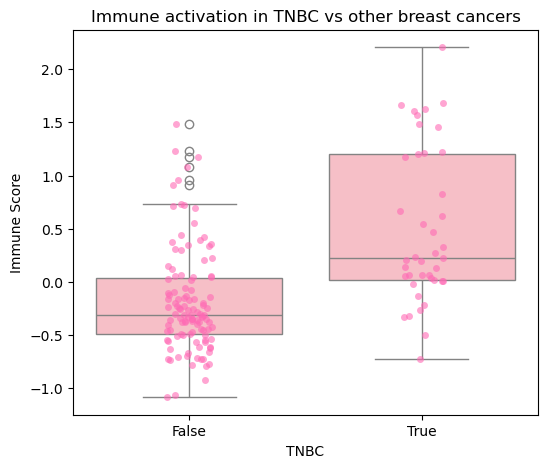

In [74]:
plt.figure(figsize=(6,5))

sns.boxplot(
    data=metadata,
    x="TNBC",
    y="Immune Score",
    color="lightpink"
)

sns.stripplot(
    data=metadata,
    x="TNBC",
    y="Immune Score",
    color="hotpink",
    alpha=0.6
)
plt.title("Immune activation in TNBC vs other breast cancers")
plt.savefig("../figures/immune_boxplot.png", dpi=300, bbox_inches="tight")

plt.show()


**Interpretation of Immune Activation Plot**

This plot compares the immune activation scores between triple-negative breast cancer (TNBC) tumors and other breast cancer subtypes.

Each point represents an individual tumor sample. The immune score was calculated as the average standardized expression of a curated panel of cytotoxic immune-related genes (including CD8A, GZMB, IFNG, CXCL9, CXCL10, and others). Higher values indicate stronger immune activation within the tumor microenvironment.

The boxplot shows that TNBC tumors (True) generally have higher immune scores than non-TNBC tumors (False). The median immune score for TNBC is above zero, while the median for non-TNBC tumors is below zero. Additionally, the TNBC group shows a wider spread of immune scores, indicating substantial variability in immune activity among TNBC patients.

This suggests that TNBC tumors tend to exhibit stronger immune infiltration or activation compared to other breast cancer subtypes, although there remains considerable heterogeneity between individual tumors. Such heterogeneity is well documented in cancer biology and reflects the presence of both immune-active (“hot”) and immune-suppressed (“cold”) tumors within the TNBC category.

Overall, this analysis supports the idea that immune activity differs across breast cancer subtypes and demonstrates how gene-expression–based immune signatures can be used to quantify tumor microenvironment characteristics.

***Statistical Test***

In [48]:
tnbc_scores = metadata[metadata["TNBC"] == True]["Immune Score"]
non_tnbc_scores = metadata[metadata["TNBC"] == False]["Immune Score"]

In [49]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(tnbc_scores, non_tnbc_scores)

print("Statistic:", stat)
print("p-value:", p)

Statistic: 3748.0
p-value: 1.0520214772753226e-08


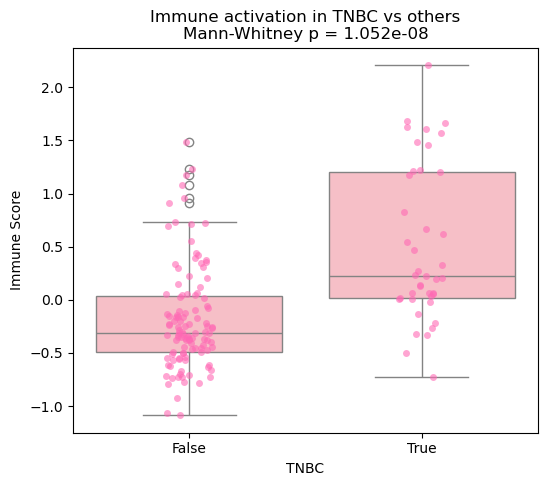

In [73]:
plt.figure(figsize=(6,5))

sns.boxplot(data=metadata, x="TNBC", y="Immune Score", color="lightpink")
sns.stripplot(data=metadata, x="TNBC", y="Immune Score", color="hotpink", alpha=0.6)
plt.title(f"Immune activation in TNBC vs others\nMann-Whitney p = {p:.3e}")
plt.savefig("../figures/Mann-Whitney.png", dpi=300, bbox_inches="tight")

plt.show()


To formally test whether immune activation differed between TNBC and non-TNBC tumors, a Mann–Whitney U test was performed comparing the distribution of immune scores between the two groups.

The test produced a p-value of 1.05 × 10⁻⁸, indicating a highly statistically significant difference in immune activation between TNBC and other breast cancer subtypes. This extremely small p-value suggests that the observed difference in immune scores is very unlikely to have occurred by random chance.

## Immune Gene Expression Heatmap
Hierarchical clustering was used to visualize immune gene expression patterns across tumors.


In [51]:
heatmap_df = immune_scaled.copy()
heatmap_df["TNBC"] = metadata["TNBC"].values


In [52]:
heatmap_df["score"] = metadata["Immune Score"].values
heatmap_df = heatmap_df.sort_values("score", ascending=False)


In [53]:
heatmap_df["score"] = metadata["Immune Score"].values
heatmap_df = heatmap_df.sort_values("score", ascending=False)


In [54]:
row_colors = heatmap_df["TNBC"].map({True:"hotpink", False:"lightgrey"})
heatmap_df = heatmap_df.drop(columns=["TNBC","score"])


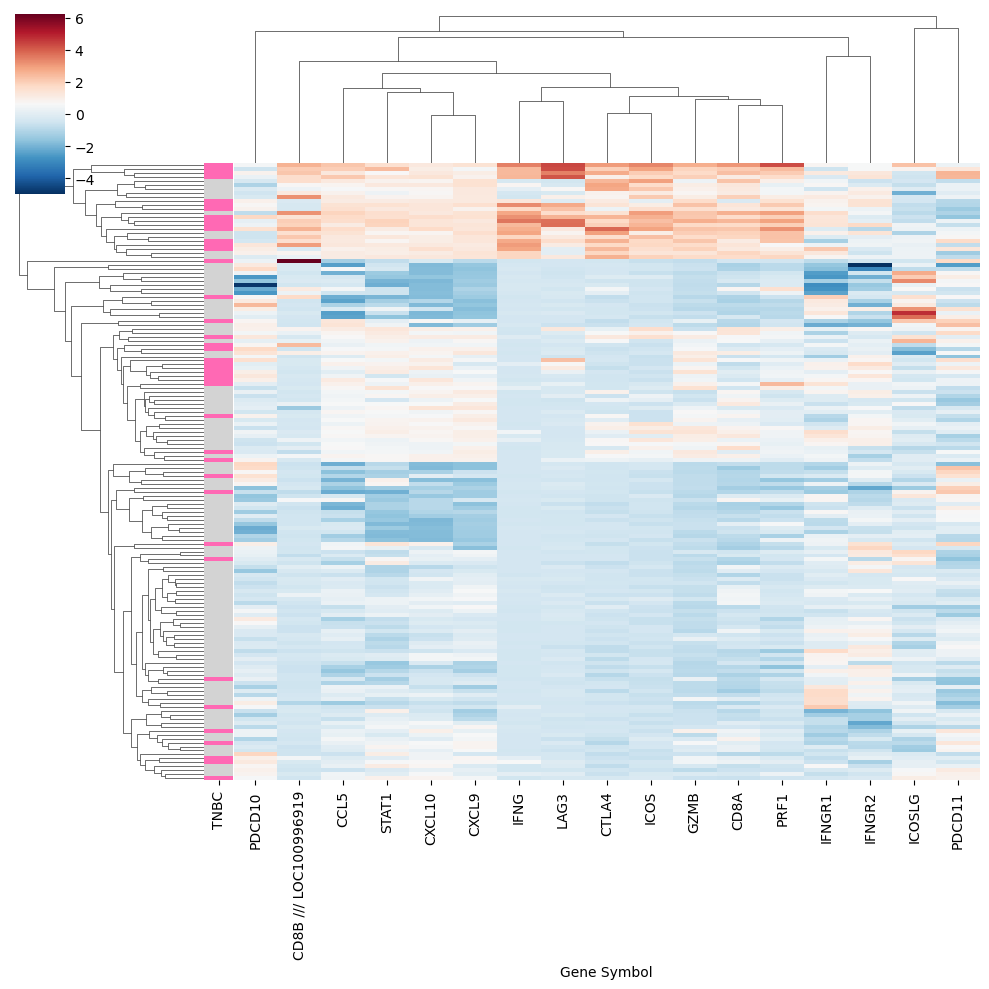

In [72]:
import seaborn as sns
sns.clustermap(
    heatmap_df,
    cmap="RdBu_r",
    row_colors=row_colors,
    figsize=(10,10),
    xticklabels=True,
    yticklabels=False
)

plt.savefig("../figures/immune_heatmap.png", dpi=300, bbox_inches="tight")



**Heatmap of Immune Gene Expression Across Tumor**

This heatmap shows the standardized expression levels of selected immune-related genes across all breast tumor samples. Each row represents a tumor sample and each column represents an immune-associated gene involved in cytotoxic T-cell activity and immune signaling. Gene expression values were standardized across samples, with red indicating higher expression and blue indicating lower expression.

Hierarchical clustering was applied to group tumors based on similarity in their immune gene expression profiles. A color bar on the left indicates tumor subtype classification, where pink corresponds to triple-negative breast cancer (TNBC) and grey corresponds to other breast cancer subtypes.

The heatmap reveals substantial heterogeneity in immune gene expression across tumors, with a subset of samples displaying consistently elevated expression of multiple immune activation genes. Many of these immune-high samples correspond to TNBC tumors, supporting the observation that TNBC often exhibits stronger immune activation compared to other breast cancer subtypes. However, the presence of both immune-high and immune-low tumors within TNBC highlights the biological diversity of the disease.

## Discovery of Immune Subtypes

Unsupervised K-means clustering was applied to identify intrinsic immune-high and immune-low tumor groups.


In [56]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(immune_scaled)


c:\Users\siyas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [57]:
metadata["ImmuneCluster"] = clusters
metadata.head()



,Sample,Subtype,TNBC,Immune Score,ImmuneCluster
0,GSM1116084,Basal,True,0.464047,1
1,GSM1116085,Basal,True,0.324664,0
2,GSM1116086,Her2,False,0.062378,0
3,GSM1116087,Basal,True,0.040608,0
4,GSM1116088,Her2,False,-0.056871,0


In [58]:
metadata.groupby("ImmuneCluster")["Immune Score"].mean()

ImmuneCluster
0   -0.284104
1    0.974070
Name: Immune Score, dtype: float64

In [59]:
metadata["ImmuneGroup"] = metadata["ImmuneCluster"].map({0:"Low",1:"High"})
pd.crosstab(metadata["ImmuneGroup"], metadata["TNBC"])


TNBC,False,True
ImmuneGroup,,
High,18,17
Low,96,24


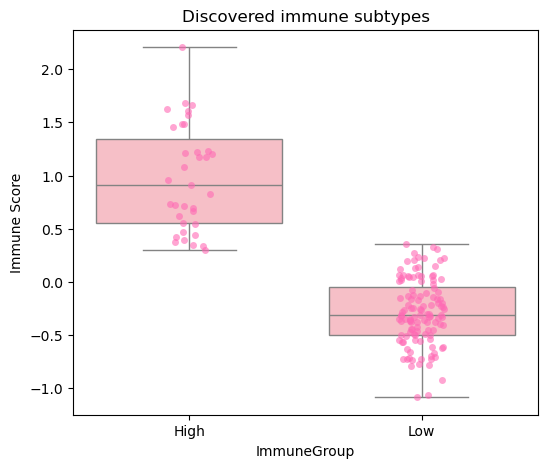

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.boxplot(data=metadata, x="ImmuneGroup", y="Immune Score", color="lightpink")
sns.stripplot(data=metadata, x="ImmuneGroup", y="Immune Score", color="hotpink", alpha=0.6)
plt.title("Discovered immune subtypes")
plt.savefig("../figures/immune_subtypes.png", dpi=300, bbox_inches="tight")

plt.show()


**Discovery of Immune Subtypes Using Unsupervised Clustering**

To identify intrinsic immune patterns within the tumor cohort, unsupervised K-means clustering was applied to standardized expression of selected immune activation genes. The algorithm grouped tumors into two clusters based solely on immune gene expression profiles.

The resulting clusters showed a clear separation in immune activity. One cluster exhibited strongly elevated immune scores and was labeled the immune-high group, while the other showed consistently lower immune scores and was labeled immune-low. Visualization confirmed minimal overlap between these groups, indicating robust separation based on immune gene expression.

Cross-tabulation with tumor subtype revealed that TNBC samples were more frequently present in the immune-high group compared to other breast cancer subtypes, supporting the observation that TNBC tumors often display increased immune activation. However, both immune-high and immune-low tumors were present within TNBC, highlighting biological heterogeneity in immune response across patients.

This analysis demonstrates that tumor immune subtypes can be discovered directly from gene expression data without prior subtype labeling.

## Predicting TNBC Status Using Immune Gene Expression

A logistic regression classifier was trained to predict TNBC status from immune gene expression.


In [61]:
X = immune_scaled.copy()
y = metadata["TNBC"].astype(int)


In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)


In [63]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [64]:
from sklearn.metrics import accuracy_score

pred = model.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)


Accuracy: 0.8297872340425532


In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.89      0.89      0.89        35
           1       0.67      0.67      0.67        12

    accuracy                           0.83        47
   macro avg       0.78      0.78      0.78        47
weighted avg       0.83      0.83      0.83        47



**Prediction of TNBC Status Using Immune Gene Expression**

To evaluate whether immune-related gene expression could predict tumor subtype, a logistic regression classifier was trained using standardized expression of selected immune activation genes. The model was evaluated on a held-out test set.

The classifier achieved an overall accuracy of approximately 83%. Performance was stronger for identifying non-TNBC tumors, while prediction of TNBC tumors showed moderate precision and recall. This indicates that immune gene expression provides meaningful information for distinguishing TNBC from other breast cancer subtypes, although immune features alone do not fully explain subtype identity.

These findings are consistent with biological expectations, as TNBC tumors often exhibit increased immune activation but remain heterogeneous across patients. Overall, this analysis demonstrates that immune-expression signatures can contribute to predictive modeling of tumor subtype.

**ROC PLOT**

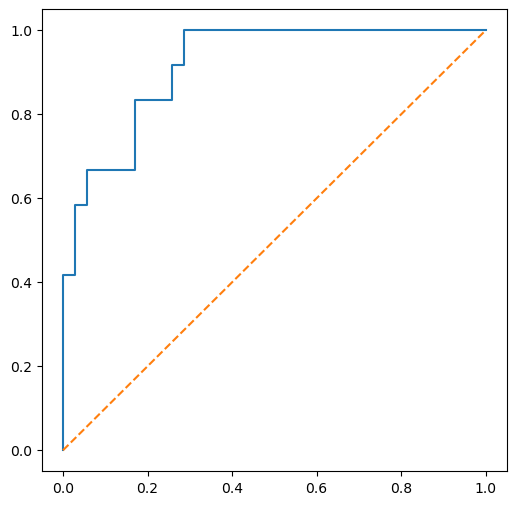

In [75]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# probability predictions
probs = model.predict_proba(X_test)[:,1]

# ROC data
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')

# Save
plt.savefig("../figures/roc_curve.png", dpi=300, bbox_inches="tight")

**Feature Importance**

In [67]:
import pandas as pd

importance = pd.Series(
    model.coef_[0],
    index=X.columns
).sort_values(key=abs, ascending=False)

importance


Gene Symbol
PDCD10                   1.398646
GZMB                     1.185154
CD8A                    -1.064671
CXCL10                   1.015108
ICOS                    -0.916649
CXCL9                    0.906434
LAG3                     0.880538
PDCD11                   0.540556
PRF1                     0.528631
IFNGR2                  -0.453486
STAT1                   -0.448431
CTLA4                   -0.355656
IFNGR1                   0.353035
ICOSLG                   0.217278
CD8B /// LOC100996919    0.198821
IFNG                     0.188051
CCL5                    -0.116743
dtype: float64

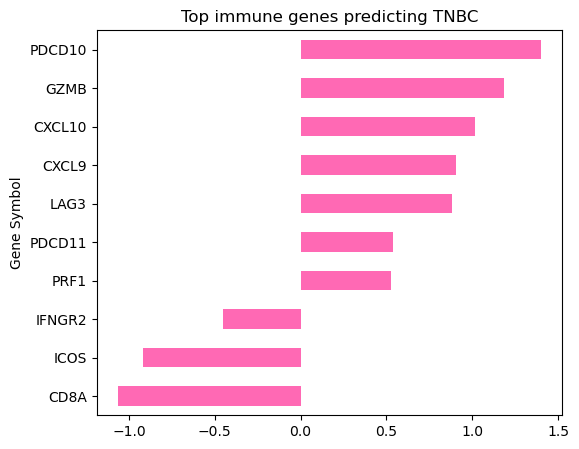

In [70]:
importance.head(10).sort_values().plot(
    kind="barh",
    figsize=(6,5),
    title= "Top immune genes predicting TNBC",
    color= "hotpink"
)
plt.savefig("../figures/top_genes.png", dpi=300, bbox_inches="tight")

plt.show()


**FINAL SUMMARY PLOT**

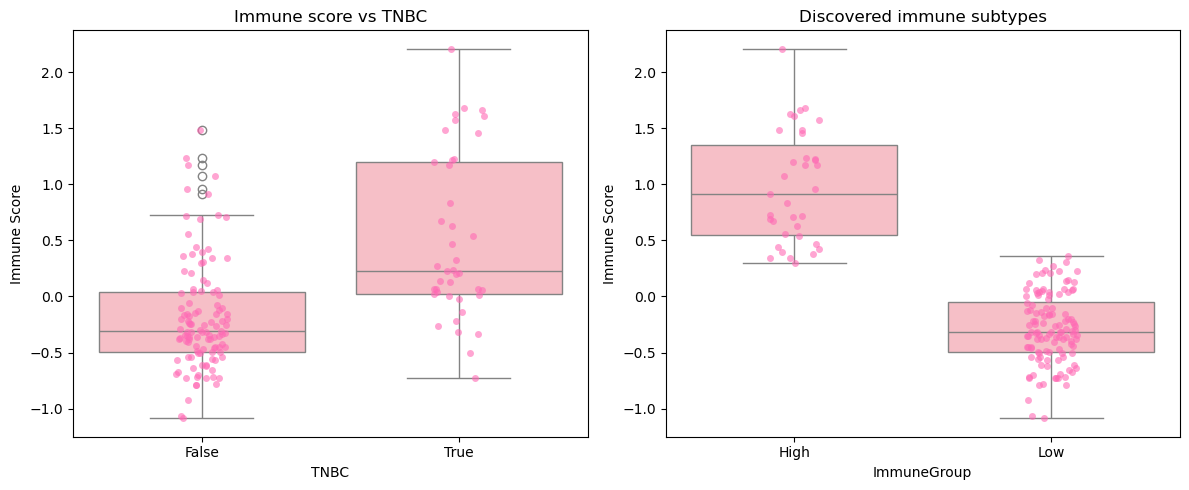

In [69]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.boxplot(data=metadata, x="TNBC", y="Immune Score",
            color="lightpink", ax=axes[0])
sns.stripplot(data=metadata, x="TNBC", y="Immune Score",
              color="hotpink", alpha=0.6, ax=axes[0])
axes[0].set_title("Immune score vs TNBC")

sns.boxplot(data=metadata, x="ImmuneGroup", y="Immune Score",
            color="lightpink", ax=axes[1])
sns.stripplot(data=metadata, x="ImmuneGroup", y="Immune Score",
              color="hotpink", alpha=0.6, ax=axes[1])
axes[1].set_title("Discovered immune subtypes")

plt.tight_layout()
plt.show()


## Conclusion

This analysis demonstrates that immune gene expression profiles provide meaningful insight into tumor biology in breast cancer.

Key findings include:

- TNBC tumors tend to exhibit higher immune activation.
- Tumors show substantial heterogeneity, forming immune-high and immune-low subgroups.
- Immune gene expression alone enables reasonably accurate prediction of TNBC status.

These results illustrate how publicly available gene expression datasets can be used to study tumor microenvironment characteristics and develop biologically interpretable predictive models.
